# Audio signal pre-processing

Audio signal data will be converted into time domain features and frequency domain features

In [1]:
import os
import math
import librosa

In [2]:
DATASET_PATH = "datasets/final_audio"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

MFCC_NUM = 13
FFT_NUM = 2048
HOP_LENGTH = 512
SEGMENTS_NUM = 5

category_labelling_map = {
  "ambulance": 0,
  "police": 1,
  "fire-and-trucks": 2,
}

# Time domain feature extraction

In [ ]:
time_domain_features = {
  "category": [],
  "labels": [],
  "data": []
}

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  time_domain_features["category"].append(category)
  time_domain_features["labels"].append(category_labelling_map[category])
  time_domain_features["data"].append(signal)

## Mel-Spectogram feature extraction on each frame of audio chunks

In [ ]:
spect_features = {
  "category": [],
  "labels": [],
  "spectogram": []
}

samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
num_spect_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  spect_features["category"].append(category)

  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  for d in range(num_segments):
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mel-spectogram
    mel_spect = librosa.feature.melspectrogram(y=signal[start:finish],
                                sr=sample_rate, n_fft=FFT_NUM,
                                hop_length=HOP_LENGTH)
    mel_spect = mel_spect.T

    # store only spectogram feature with expected number of vectors
    if len(mel_spect) == num_spect_vectors_per_segment:
      spect_features["spectogram"].append(mel_spect.tolist())
      spect_features["labels"].append(category_labelling_map[category])

# MFCC feature extraction on each frame of audio chunks

In [ ]:
mfcc_feature = {
  "category": [],
  "labels": [],
  "mfcc": []
}

samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

for i, f in enumerate(os.listdir(DATASET_PATH)):
  file_path = os.path.join(DATASET_PATH, f)
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  # number of segments based on duration
  num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1

  category = f.split("_")[0]
  mfcc_feature["category"].append(category)

  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

  for d in range(num_segments):
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish],
                                sr=sample_rate, n_mfcc=MFCC_NUM, n_fft=FFT_NUM,
                                hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    # store only mfcc feature with expected number of vectors
    if len(mfcc) == num_mfcc_vectors_per_segment:
      mfcc_feature["mfcc"].append(mfcc.tolist())
      mfcc_feature["labels"].append(category_labelling_map[category])

## We will be using `mfcc_feature` variable on ML algorithms 

## Algorithms consideration:
- SVM
- Logistic Regression
- Decision Tree
- Convolutional Neural Network
- LSTM

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [7]:
X = np.array(mfcc_feature["mfcc"])
y = np.array(mfcc_feature["labels"])
X.shape

(160, 259, 13)

In [8]:
# Reshape X to 2D array where each row represents a sample and each column represents a feature
samples, frames, ft_per_frame = X.shape
X_reshaped = X.reshape(samples, -1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y,
                                                    test_size=0.2, random_state=42)

# Support Vector Machine / SVM

In [23]:
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train, y_train)
svm_predictions = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_accuracy

0.53125

# Logistic Regression Classifier

In [24]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_predictions = lr_clf.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_accuracy

0.65625

# Decision Tree Classifier

In [25]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_predictions = dt_clf.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_accuracy

0.40625

# Convolutional Neural Network

In [40]:
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)
import matplotlib.pyplot as plt

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_train.shape

(128, 259, 13, 1)

In [42]:
cnn_model = Sequential([
  Conv2D(32, (3, 3), activation='relu',
         input_shape=(X_train.shape[1], X_train.shape[2], 1)),
  MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  Conv2D(32, (2, 2), activation='relu'),
  MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
  BatchNormalization(),
  
  # flatten output
  Flatten(),
  Dense(64, activation='relu'),
  Dropout(0.3),
  
  # output
  Dense(3, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              # loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 129, 6, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_27 (Ba  (None, 129, 6, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_28 (Conv2D)          (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 64, 2, 32)         0         
 ng2D)                                                           
                                                      

In [43]:
cnn_history = cnn_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=150)

Epoch 1/150
4/4 [==============================] - 1s 47ms/step - loss: 1.4757 - accuracy: 0.3594 - val_loss: 2.5578 - val_accuracy: 0.4062
Epoch 2/150
4/4 [==============================] - 0s 24ms/step - loss: 1.3450 - accuracy: 0.4375 - val_loss: 2.3602 - val_accuracy: 0.4375
Epoch 3/150
4/4 [==============================] - 0s 23ms/step - loss: 1.0484 - accuracy: 0.5469 - val_loss: 2.2876 - val_accuracy: 0.4375
Epoch 4/150
4/4 [==============================] - 0s 22ms/step - loss: 1.0346 - accuracy: 0.5391 - val_loss: 2.2308 - val_accuracy: 0.4375
Epoch 5/150
4/4 [==============================] - 0s 23ms/step - loss: 0.8815 - accuracy: 0.6172 - val_loss: 2.2016 - val_accuracy: 0.4375
Epoch 6/150
4/4 [==============================] - 0s 23ms/step - loss: 0.7463 - accuracy: 0.6406 - val_loss: 2.1653 - val_accuracy: 0.4375
Epoch 7/150
4/4 [==============================] - 0s 22ms/step - loss: 0.7592 - accuracy: 0.6797 - val_loss: 2.1333 - val_accuracy: 0.4375
Epoch 8/150
4/4 [===

In [44]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)
f'Loss: {cnn_loss}, Accuracy: {cnn_accuracy}'

1/1 - 0s - loss: 1.2074 - accuracy: 0.6562 - 19ms/epoch - 19ms/step


'Loss: 1.2073951959609985, Accuracy: 0.65625'

## Accuracy and Error graph

In [49]:
def acc_err_plot(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  
  plt.tight_layout()
  plt.show()

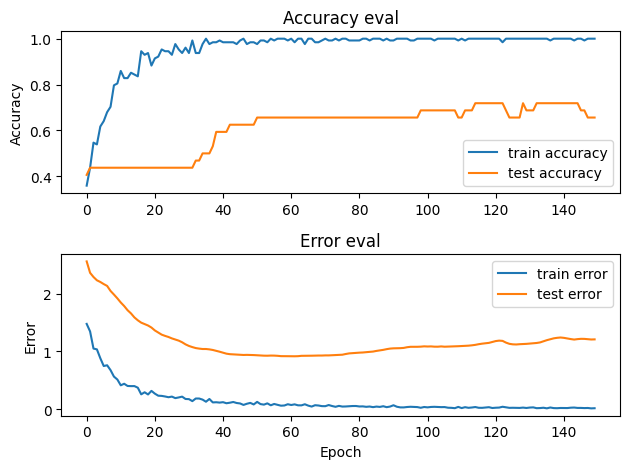

In [50]:
acc_err_plot(cnn_history)

# LSTM

In [60]:
from tensorflow.keras.layers import LSTM

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [62]:
lstm_model = Sequential([
  LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),
       return_sequences=True),
  LSTM(64),
  
  Dense(64, activation='relu'),
  Dropout(0.3),
  
  # output
  Dense(3, activation='softmax')
])

In [63]:
lstm_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              # loss='categorical_crossentropy',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 259, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 3)                 195       
                                                                 
Total params: 57347 (224.01 KB)
Trainable params: 57347 (224.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
lstm_history = lstm_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=150)

Epoch 1/150
4/4 [==============================] - 2s 199ms/step - loss: 1.1498 - accuracy: 0.2578 - val_loss: 1.1778 - val_accuracy: 0.2188
Epoch 2/150
4/4 [==============================] - 0s 92ms/step - loss: 1.1266 - accuracy: 0.2891 - val_loss: 1.1653 - val_accuracy: 0.1875
Epoch 3/150
4/4 [==============================] - 0s 90ms/step - loss: 1.0815 - accuracy: 0.4609 - val_loss: 1.1532 - val_accuracy: 0.1875
Epoch 4/150
4/4 [==============================] - 0s 91ms/step - loss: 1.0971 - accuracy: 0.3984 - val_loss: 1.1422 - val_accuracy: 0.2188
Epoch 5/150
4/4 [==============================] - 0s 92ms/step - loss: 1.0853 - accuracy: 0.4609 - val_loss: 1.1307 - val_accuracy: 0.2812
Epoch 6/150
4/4 [==============================] - 0s 89ms/step - loss: 1.0691 - accuracy: 0.4297 - val_loss: 1.1216 - val_accuracy: 0.3438
Epoch 7/150
4/4 [==============================] - 0s 90ms/step - loss: 1.0632 - accuracy: 0.4453 - val_loss: 1.1136 - val_accuracy: 0.4062
Epoch 8/150
4/4 [==

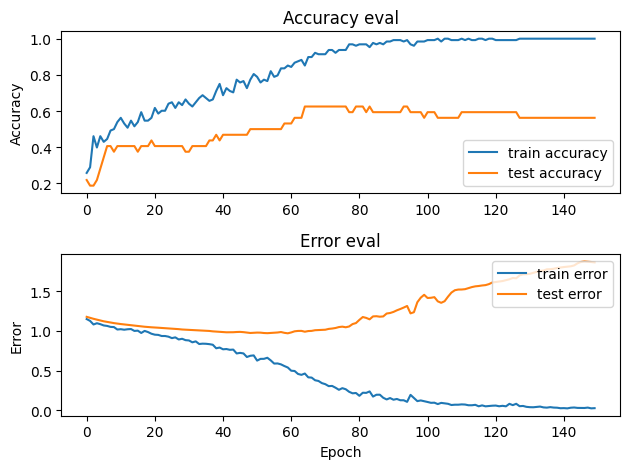

In [65]:
acc_err_plot(lstm_history)

## Prediction

In [66]:
import random

In [89]:
def find_category(value):
  for key, val in category_labelling_map.items():
      if val == value:
          return key
  raise "Error: Not found this value"

In [90]:
def prediction_by_model(model):
  rnd_test_index = random.randint(0, len(X_test))

  x_to_predict = X_test[rnd_test_index]
  y_to_predict = y_test[rnd_test_index]
  
  # add 1 dimension to input data for sample - model.predict() expects a 4d array in this case
  x_to_predict = x_to_predict[np.newaxis, ...]
  
  prediction = model.predict(x_to_predict)
  
  predicted_index = np.argmax(prediction, axis=1)
  
  print(f"Target: {find_category(y_to_predict)}, Predicted label: {find_category(predicted_index)}; test index: {rnd_test_index}")

In [102]:
prediction_by_model(cnn_model)

1/1 [==============================] - 0s 17ms/step
Target: ambulance, Predicted label: ambulance; test index: 30


In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score